In [1]:
pip install phik catboost shap

# Классификация музыки

**Задача** - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

**Данные** - датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры.

План работы:
* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков,
* вывод.

## 1. Загрузка и ознакомление с данными

Импортируем все необходимые для работы библиотеки.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score

Прочитаем файлы с данными и ознакомимся с их содержимым.

In [3]:
data_train = pd.read_csv('kaggle_music_genre_train.csv')
data_test = pd.read_csv('kaggle_music_genre_test.csv')

In [4]:
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [5]:
print(data_test.info())
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB
None


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


**Вывод:** открыли и изучили таблицы с данными.

Даны тренировочный и тестовый датафреймы. Тренировочный датафрейм содержит столбцы в количестве 11 - типа float64 и 5 - типа object. Тестовый - 15 столбцов с данными, из которых 10 - типа float64, 1 - типа int64 и 4 - типа object. Столбец `instance_id` тренировочного датафрейма имеет тип `float`, необходимо будет его исправить.В обеих таблицах видны пропуски в колонках `key`, `mode` и `tempo`.

Далее перейдем к предварительной обработке и полноценному разведочному анализу данных.

# 2. Предварительная обработка и разведочный анализ

In [6]:
data_train.duplicated().sum(), data_test.duplicated().sum()

(0, 0)

Явные дубликаты не обнаружены.

Изменим тип данных столбца `instance_id` на `int`.

In [7]:
data_train['instance_id'] = data_train['instance_id'].astype(int)

Далее рассмотрим все числовые признаки.

In [8]:
display(data_train.describe())
data_test.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000


Видим, что значения в колонке с продолжительностью могут быть меньше нуля, заполним такие значения средним по столбцу.

In [9]:
def mean_duration(dataframe):
    mean_dur = dataframe[dataframe['duration_ms'] > 0]['duration_ms'].mean()
    result = dataframe['duration_ms'].apply(lambda x: mean_dur if x <= 0 else x)
    return result

data_train['duration_ms'] = mean_duration(data_train)
data_test['duration_ms'] = mean_duration(data_test)

Далее заполним пропуски
 - в столбце `key` заполним пропуски наиболее часто встречающимися значениями
 - в столбце `tempo`, судя по среднему и медианному значению выбросы отсутствуют, заполним пропуски средним значением.

Столбец `mode` имеет бинарные значения, заполнять его не будем, заменим `Nan` на `unknown`.

In [10]:
def fill(row):
    key_mode = row['key'].mode().item()
    row['key'] = row['key'].fillna(key_mode)
    temp_mean = row['tempo'].mean().item()
    row['tempo'] = row['tempo'].fillna(temp_mean)

fill(data_train)
fill(data_test)

In [11]:
data_train = data_train.fillna('unknown')
data_test = data_test.fillna('unknown')

Рассмотрим числовые колонки на предмет выбросов и аномалий.

In [12]:
numeric = data_train.select_dtypes(include='float64').columns.tolist()

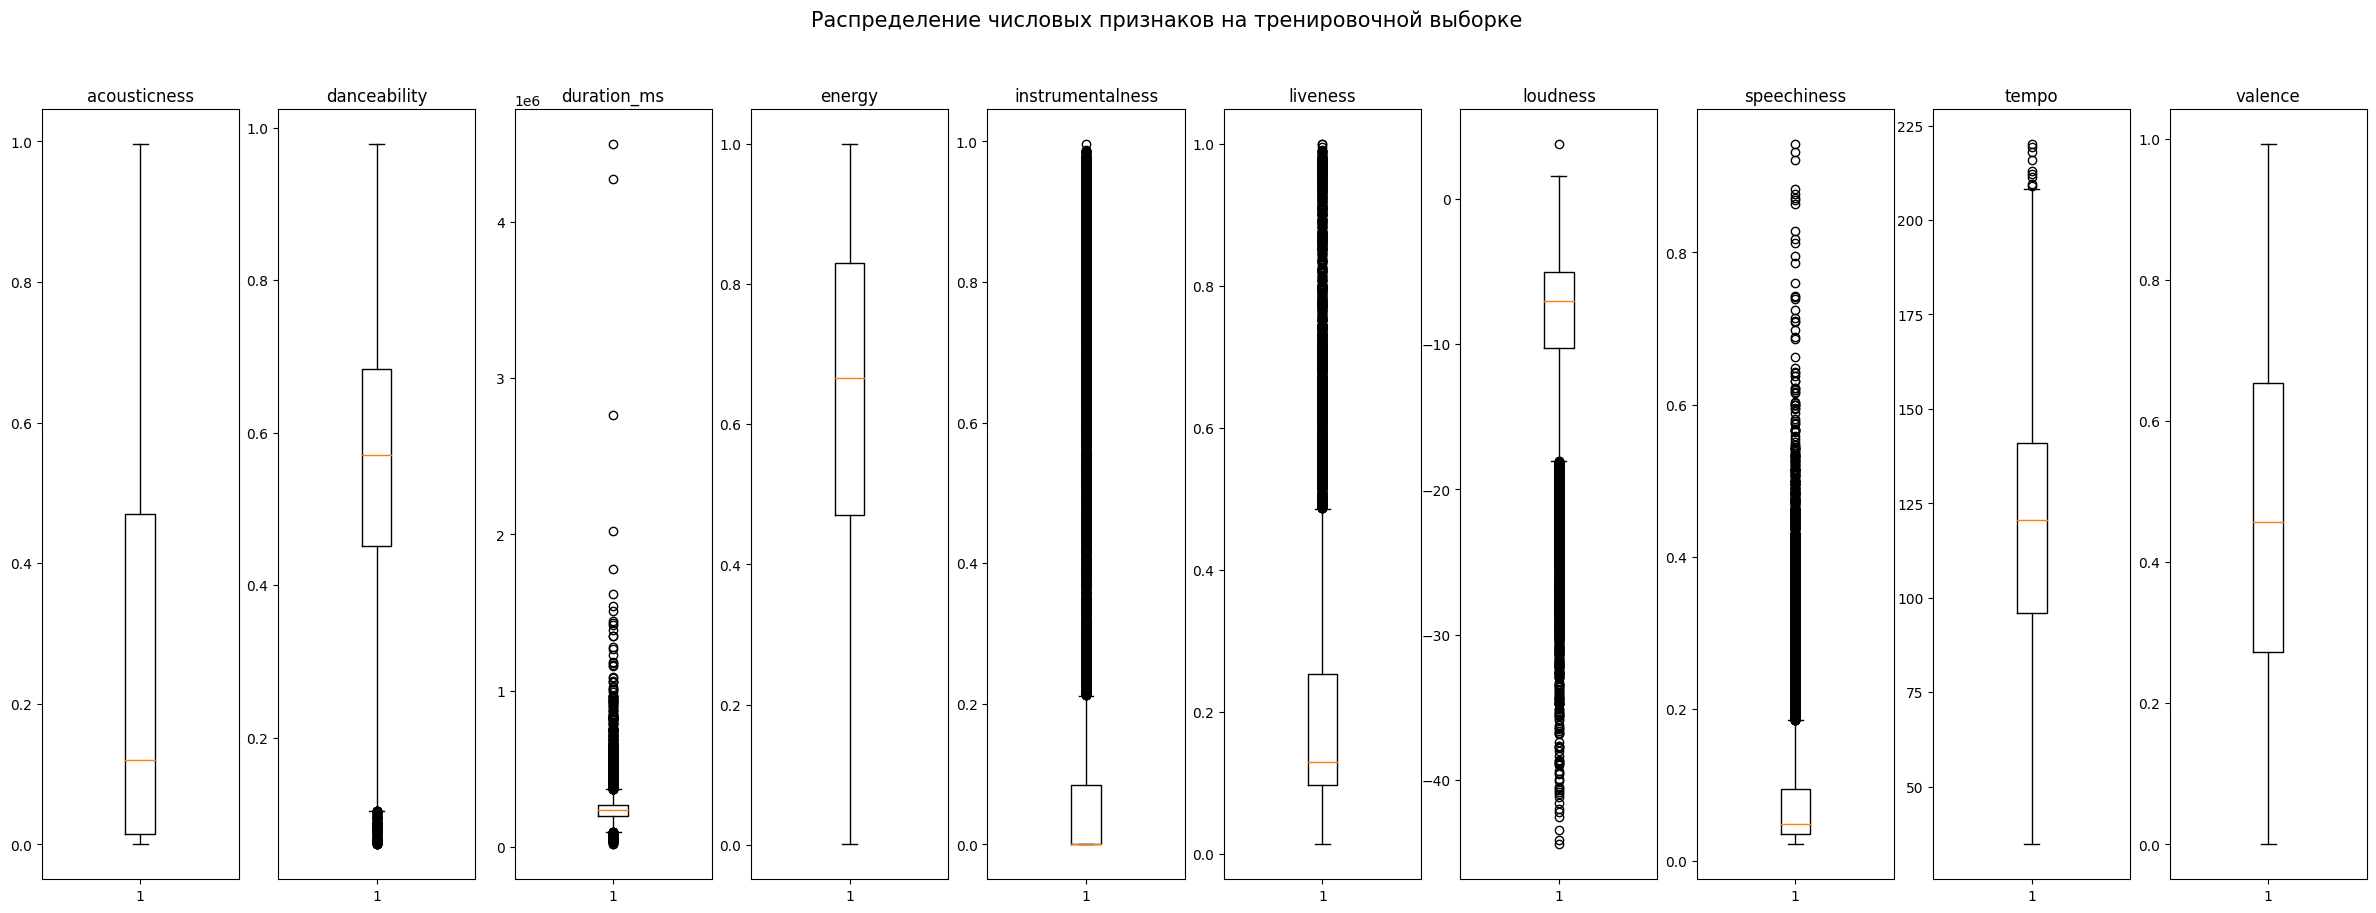

In [13]:
fig, axs = plt.subplots(1, 10)
ax = axs.ravel()
plt.figure
fig.suptitle('Распределение числовых признаков на тренировочной выборке', fontsize=15)
fig.set_size_inches(30, 10)
for i, num in enumerate(numeric):
    ax[i].boxplot(data_train[num])
    ax[i].set_title(num)
plt.show()

Далее избавимся от выбросов.

Оставим данные, подходящие по следующим параметрам:
* песни продолжительностью менее 1800000 мс;
* громкость от -40 до 0 дБ;
* темп от 10 до 240.

In [14]:
data_train = data_train.query('(duration_ms < 1800000) & (loudness > -40) & (loudness < 0) & (tempo > 10) & (tempo < 240)')

**Вывод по второму шагу:** в тренировочном датафрейме заменили тип данных в столбце `instance_id` на `int`. После чего обнаружили аномальные значения в столбце с продолжительностью, заполнили их средним значением по столбцу. Затем выявили пропуски и избавились от них, где возможно. После чего провели исследование на предмет выбросов и избавились от них в столбцах с `duration_ms`, `loudness`и `tempo`.

В следующем шаге можем перейти к подготовке данных для обучения моделей, в том числе переработке некоторых численных признаков, а именно:
* `liveness` можно сгруппировать на два значения по границе равной 0,8;
* `speechiness` можно сгруппировать в три категории.

# 3. Подготовка данных для обучения моделей.

Сгруппируем `liveness` на два значения по границе равной 0,8, нижний промежуток сделаем равным 0, верхний - 1.

In [15]:
def cat_liveness(data):
    if data <= 0.8:
        return 0
    else:
        return 1

data_train['liveness'] = data_train['liveness'].apply(lambda x: cat_liveness(x)).astype(int)
data_test['liveness'] = data_test['liveness'].apply(lambda x: cat_liveness(x)).astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cгруппируем `speechiness` в три категории: low(<0.33), mid(0.33:0.66) и high(>0.66).

In [16]:
def speech_group(data):
    if data < 0.33:
        return 'low'
    elif data > 0.66:
        return 'high'
    else:
        return 'mid'

data_train['speechiness'] = data_train['speechiness'].apply(lambda x: speech_group(x))
data_test['speechiness'] = data_test['speechiness'].apply(lambda x: speech_group(x))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Выполним проверку признаков на мультиколлениарность при помощи библиотеки `phik`.

In [17]:
phik_overview = data_train.phik_matrix()

The number of unique values of variable track_name is large: 18608. Are you sure this is not an interval variable? Analysis for pairs of variables including track_name can be slow.


interval columns not set, guessing: ['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence']


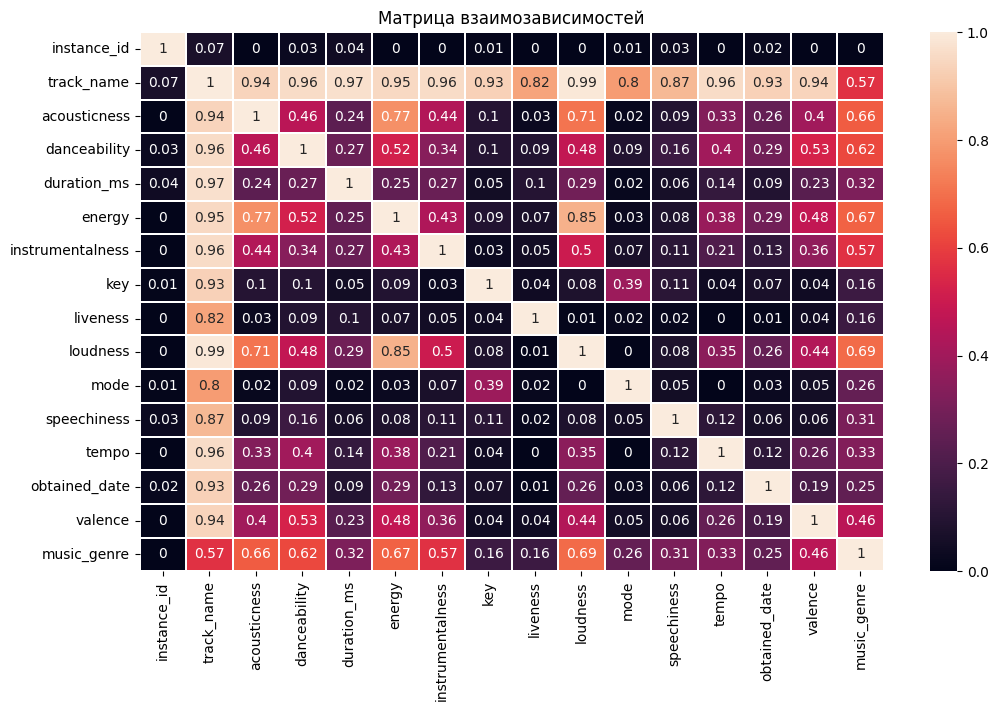

In [18]:
plt.figure(figsize=(12, 7))
corr_matrix = phik_overview
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidth= 0.3)
plt.title('Матрица взаимозависимостей')
plt.show()

Колонка`track_name` имеет слишком высокую корреляцию практически со всеми признаками, уберем ее при обучении и тестировании моддели.

In [19]:
data_train = data_train.drop('track_name', axis=1)
data_test = data_test.drop('track_name', axis=1)

**Вывод:** изменили признаки `liveness` и `speechiness`, сделави их категориальными. Избавились от колонки `track_name` из-за высокой степени корреляции почти со всеми другими колонками. Тем самым мы сформировали окончательный набор обучающих признаков.

Перейдем к созданию пайплайна, и проверке различных моделей с целью выбора лучшей.

## 4. Выбор и обучение моделей

Выделим числовые и категориальные признаки, а также целевой.

In [20]:
data_train.columns.tolist()

['instance_id',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'obtained_date',
 'valence',
 'music_genre']

In [21]:
cat_features = ['key',
 'liveness',
 'mode',
 'speechiness',
 'obtained_date']
num_features = ['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'tempo',
 'valence']
target_column = 'music_genre'

Зададим датафреймы с указанными признаками и разделим их на обучающую и тестовую части.

In [22]:
X = data_train[cat_features + num_features]
y = data_train[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cоздадим пайплайны, разделив на категориальные и числовые, после чего объединим в один общий.

In [23]:
numeric_pipeline = make_pipeline(SimpleImputer(), StandardScaler())

categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))

In [24]:
col_trans = make_column_transformer((numeric_pipeline, num_features),
    (categorical_pipeline, cat_features), remainder='passthrough', n_jobs=-1)

Далее обучим несколько моделей, воспользуемся пайплайном, подберем гиперпараметры при помощи `GridSearchCV` и оценим значение метрики `f1_micro`.

### Дерево решений

In [25]:
dtc = DecisionTreeClassifier(random_state=42)

In [26]:
pipeline_dtc = Pipeline([
    ('col_trans', col_trans),
    ('model', dtc)
])

In [27]:
dtc_params = {'model__max_depth': range(5, 11)}

In [28]:
gsc_dtc = GridSearchCV(pipeline_dtc, dtc_params, scoring='f1_micro', n_jobs=-1, cv=5)

In [29]:
gsc_dtc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['key',
                                                                          'liveness',
                                                                          'mode',
                                                                          'speechiness',
                                                                          'obtained_date'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1, param_grid={'model__max_depth': range(5, 11)},
             scoring='f1_micro')

In [30]:
gsc_dtc.best_params_

{'model__max_depth': 10}

In [31]:
gsc_dtc.best_score_

0.388984880843131

### Случайный лес

In [32]:
rfc = RandomForestClassifier(random_state=42)

In [33]:
pipeline_rfc = Pipeline([
    ('col_trans', col_trans),
    ('model', rfc)
])

In [34]:
params_rfc = ({'model__max_depth':range(9, 15),
            'model__n_estimators':range(200, 300, 20),
             })

In [35]:
gsc_rfc = GridSearchCV(pipeline_rfc, params_rfc, scoring='f1_micro', n_jobs=-1, cv=5)

In [36]:
gsc_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['key',
                                                                          'liveness',
                                                                          'mode',
                                                                          'speechiness',
                                                                          'obtained_date'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': range(9, 15),
                         'model__n_estimators': range(200, 300, 20)},
             scoring='f1_micro')

In [37]:
gsc_rfc.best_params_

{'model__max_depth': 12, 'model__n_estimators': 220}

In [38]:
gsc_rfc.best_score_

0.4464570713538937

### Логистическая регрессия

In [39]:
lr = LogisticRegression(random_state=42, multi_class='ovr')

In [40]:
pipeline_lr = Pipeline([
    ('col_trans', col_trans),
    ('model', lr)
])

In [41]:
params_lr = ({'model__max_iter':range(1000, 10000, 1000),
            'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             })

In [42]:
gsc_lr = GridSearchCV(pipeline_lr, params_lr, scoring='f1_micro', n_jobs=-1, cv=5)

In [43]:
gsc_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('...
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['key',
                                                                          'liveness',
                                                                          'mode',
                                                                          'speechiness',
                                                                          'obtained_date'])])),
                                       ('model',
                                        LogisticRegression(multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_iter': range(1000, 10000, 1000),
                         'model__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga']},
             scoring='f1_micro')

In [44]:
gsc_lr.best_params_

{'model__max_iter': 1000, 'model__solver': 'newton-cg'}

In [45]:
gsc_lr.best_score_

0.3852392909977339

### CatBoost

Для Кэтбуста алгоритм несколько отличается.

Для начала создадим пул.

In [46]:
pool = Pool(
            data=X_train,
            label=y_train,
            cat_features=cat_features
            )

Далее зададим параметры.

In [47]:
params = { 'leaf_estimation_method': 'Gradient',
    'learning_rate': 0.1,
    'max_depth': 2,
    'bootstrap_type': 'Bernoulli',
    'objective': 'MultiClass',
    'subsample': 0.66,
    'random_state': 42,
    'verbose': 0,
    "eval_metric" : 'TotalF1',
    "early_stopping_rounds" : 100}

Обучим модель.

In [48]:
model = CatBoostClassifier(**params)
model.fit(pool)


Далее кроссвалидация.

In [49]:
cv_params = {'loss_function':'MultiClass',
             'iterations':150,
             'depth':2,
             'verbose':False,
             'random_state':42,
             'custom_loss':'TotalF1',
             'learning_rate': 0.1}

cv_data_train = cv(pool=pool,
                 params=cv_params,
                 fold_count=5,
                 shuffle=True,
                 verbose=False,
                 plot=True)

cv_data_train

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.606066455
bestIteration = 149

Training on fold [1/5]

bestTest = 1.593396917
bestIteration = 149

Training on fold [2/5]

bestTest = 1.56489473
bestIteration = 149

Training on fold [3/5]

bestTest = 1.569367332
bestIteration = 149

Training on fold [4/5]

bestTest = 1.580039687
bestIteration = 149



,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std,test-TotalF1-mean,test-TotalF1-std,train-TotalF1-mean,train-TotalF1-std
0,0,2.237866,0.000948,2.237434,0.000313,0.137085,0.002916,0.137822,0.003232
1,1,2.192857,0.002202,2.191581,0.001576,0.164482,0.019006,0.165336,0.017857
2,2,2.157620,0.002265,2.156246,0.000754,0.176075,0.007883,0.176906,0.006281
3,3,2.124220,0.003536,2.122408,0.001297,0.199205,0.022126,0.200903,0.021884
4,4,2.091950,0.005224,2.089342,0.004391,0.209054,0.028109,0.211297,0.027253
...,...,...,...,...,...,...,...,...,...
145,145,1.585649,0.016890,1.564650,0.006966,0.390688,0.007633,0.397699,0.003422
146,146,1.584956,0.016999,1.563917,0.006840,0.390596,0.006978,0.397802,0.003321
147,147,1.583936,0.017073,1.562866,0.006910,0.390682,0.007634,0.398309,0.003489
148,148,1.583213,0.016988,1.561889,0.006998,0.390098,0.008540,0.398608,0.003578


In [50]:
model.get_best_score()

{'learn': {'TotalF1': 0.4407923291840598, 'MultiClass': 1.448008417644465}}

Лучшая модель.

In [51]:
best_model = CatBoostClassifier(
    random_seed=42,
    iterations=int(model.tree_count_ * 1.2),
)
best_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False
)

Рассчитаем F1-меру для нее.

In [52]:
prediction = best_model.predict(X_train)
f1_score(y_train, prediction, average='micro')

0.6139629129313521

**Вывод:** проверили 4 модели. Дерево решений показало значение метрики равное 0,389, случайный лес - 0,45, логистическая регрессия - 0,385. Лучше всех себя показал CatBoost, с метрикой равной 0,61.

## 5. Итоговая оценка качества предсказания лучшей модели

In [53]:
best_model_predictions = best_model.predict(X_test)
f1_score(y_test, best_model_predictions, average='micro')

0.4535854616895874

Точность предсказания упала до 0,45 по сравнению с тренировочной выборкой.

Сформируем набор данных для загрузки на Kaggle.

In [54]:
genres = best_model.predict(data_test[cat_features + num_features])

names = []
for group in genres:
    names.extend(group)

data_test['music_genre'] = names
data_test

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,48564,0.301000,0.757,146213.000000,0.679,0.00000,A#,0,-7.136,Minor,mid,90.361,4-Apr,0.895,Hip-Hop
1,72394,0.538000,0.256,240360.000000,0.523,0.00832,G#,0,-5.175,Major,low,78.385,4-Apr,0.318,Alternative
2,88081,0.005830,0.678,284000.000000,0.770,0.00000,A,0,-4.399,Minor,low,90.000,4-Apr,0.412,Rap
3,78331,0.020300,0.592,177354.000000,0.749,0.00000,B,0,-4.604,Major,low,160.046,4-Apr,0.614,Country
4,72636,0.000335,0.421,241505.422876,0.447,0.01480,D,0,-8.833,Major,low,73.830,4-Apr,0.121,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,50532,0.108000,0.558,163049.000000,0.767,0.00000,E,0,-4.561,Minor,low,158.019,4-Apr,0.715,Country
5095,26255,0.131000,0.435,196216.000000,0.641,0.00000,A#,0,-7.274,Major,low,115.534,3-Apr,0.156,Country
5096,67924,0.152000,0.756,243373.000000,0.787,0.00000,D,0,-7.423,Major,low,123.405,4-Apr,0.459,Rap
5097,79778,0.001450,0.489,185600.000000,0.974,0.63800,F#,0,-2.857,Minor,low,150.036,4-Apr,0.665,Electronic


In [55]:
submit = data_test[['instance_id', 'music_genre']]
submit

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Country
4,72636,Alternative
...,...,...
5094,50532,Country
5095,26255,Country
5096,67924,Rap
5097,79778,Electronic


In [56]:
submit.to_csv(r'submit.csv', index= False)

## 6. Анализ важности признаков лучшей модели

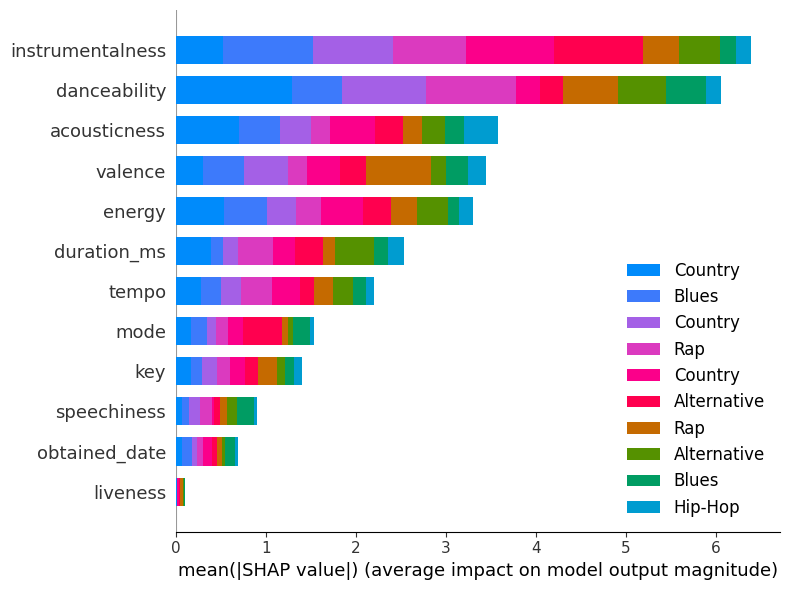

In [57]:
shap_test = shap.TreeExplainer(best_model).shap_values(data_test[cat_features + num_features])
shap.summary_plot(shap_test, data_test[cat_features + num_features],
                      max_display=25, plot_size=(8,6), class_names=data_test['music_genre'])

**Вывод:** наибольшее влияние на предсказание жанра  оказывают инструментальность и танцевальность, наименьшее - исполнение трка вживую. Наиболее часто предсказывается жанр - Кантри,наименее часто - Хип-Хоп.

## 7. Общий вывод

**Общий вывод:** открыли и изучили таблицы с данными.

Даны тренировочный и тестовый датафреймы. Тренировочный датафрейм содержит столбцы в количестве 11 - типа float64 и 5 - типа object. Тестовый - 15 столбцов с данными, из которых 10 - типа float64, 1 - типа int64 и 4 - типа object. Столбец `instance_id` тренировочного датафрейма имеет тип `float`, необходимо будет его исправить.В обеих таблицах видны пропуски в колонках `key`, `mode` и `tempo`.

В тренировочном датафрейме заменили тип данных в столбце `instance_id` на `int`. После чего обнаружили аномальные значения в столбце с продолжительностью, заполнили их средним значением по столбцу. Затем выявили пропуски и избавились от них, где возможно. После чего провели исследование на предмет выбросов и избавились от них в столбцах с `duration_ms`, `loudness`и `tempo`.

Далее изменили признаки `liveness` и `speechiness`, сделави их категориальными. Избавились от колонки `track_name` из-за высокой степени корреляции почти со всеми другими колонками. Тем самым мы сформировали окончательный набор обучающих признаков.

Затем проверили 4 модели. Дерево решений показало значение метрики равное 0,389, случайный лес - 0,45, логистическая регрессия - 0,385. Лучше всех себя показал CatBoost, с метрикой равной 0,61.

В результате обучения на тестовой выборке можем сказать, что наибольшее влияние на предсказание жанра  оказывают инструментальность и танцевальность, наименьшее - исполнение трка вживую. Наиболее часто предсказывается жанр - Кантри,наименее часто - Хип-Хоп.